# Structure from Motion

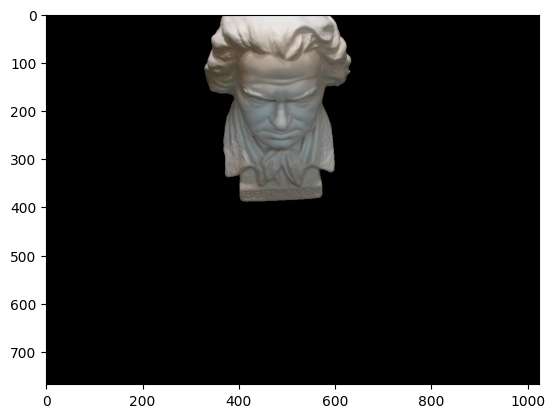

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

images = [os.path.join('beethoven/images/', path) for path in sorted(os.listdir('beethoven/images/'))]
silhouettes = [os.path.join('beethoven/silhouettes/', path) for path in sorted(os.listdir('beethoven/silhouettes/'))]

def get_masked_img(index):
    img = cv2.imread(images[index])
    silhouette = cv2.imread(silhouettes[index], cv2.IMREAD_GRAYSCALE)
    
    inv_silhouette = cv2.bitwise_not(silhouette)
    
    masked_img = cv2.bitwise_and(img, img, mask=inv_silhouette)
    
    return masked_img

img = get_masked_img(0)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))